#Import

In [2]:
# if open from google colab, run this command
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/MyDrive/data-retail/data-train
%cd /content/drive/MyDrive/data-train-new
# %cd /content/drive/MyDrive/Github/sales-prediction-gru/ipynb
# %cd /content/drive/Shareddrives/BUAT\ DIEGO/data-retail/data-train-new

Mounted at /content/drive
/content/drive/MyDrive/data-train-new


In [3]:
import os, warnings, random

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model, callbacks
from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline 

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import joblib
from keras.models import load_model

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data_series = pd.read_csv('./data_series_2018_2021_limit500.csv')

In [5]:
data_series.drop(data_series.iloc[:, :1], inplace = True, axis = 1)

In [6]:
data_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966852 entries, 0 to 966851
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       966852 non-null  float64
 1   1       966852 non-null  float64
 2   2       966852 non-null  float64
 3   3       966852 non-null  float64
 4   4       966852 non-null  float64
 5   5       966852 non-null  float64
 6   6       966852 non-null  float64
 7   7       966852 non-null  float64
 8   8       966852 non-null  float64
 9   9       966852 non-null  float64
 10  10      966852 non-null  float64
 11  11      966852 non-null  float64
 12  label   966852 non-null  float64
dtypes: float64(13)
memory usage: 95.9 MB


In [7]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)
print("Train set", train.shape)
print("Validation set", valid.shape)
az = train.sort_index(axis = 0)
az.head()

Train set (870166, 12)
Validation set (96686, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,14.40,12.55,19.50,15.83,13.72,19.72,20.78,19.90,12.00,11.78,14.68,14.05
1,12.55,19.50,15.83,13.72,19.72,20.78,19.90,12.00,11.78,14.68,14.05,18.69
2,19.50,15.83,13.72,19.72,20.78,19.90,12.00,11.78,14.68,14.05,18.69,15.35
3,15.83,13.72,19.72,20.78,19.90,12.00,11.78,14.68,14.05,18.69,15.35,20.38
4,13.72,19.72,20.78,19.90,12.00,11.78,14.68,14.05,18.69,15.35,20.38,13.80


In [8]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))
print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (870166, 12, 1)
Validation set reshaped (96686, 12, 1)


# 2020 - 2021 with kategori bs64

In [9]:
def auto_model(batch, neuron, month, first_year, end_year):
  serie_size =  X_train.shape[1] # 12
  n_features =  X_train.shape[2] # 1
  epochs = 1000
  lr = 0.0001

  gru_model = Sequential()
  gru_model.add(L.GRU(neuron, input_shape=(serie_size, n_features)))
  gru_model.add(L.Dense(1, activation='linear'))
  adam = optimizers.Adam(lr)
  gru_model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])

  early_stop = callbacks.EarlyStopping(patience = 10)
  gru_history = gru_model.fit(X_train, Y_train, 
                                validation_data=(X_valid, Y_valid), 
                                batch_size=batch, 
                                epochs=epochs, 
                                verbose=2,
                                callbacks=[early_stop])
  gru_model.save(f"gru_model-bs{batch}_hn{neuron}_month{month}_year{first_year}-{end_year}_limit500.h5")

  lstm_train_pred = gru_model.predict(X_train)
  lstm_val_pred = gru_model.predict(X_valid)
  print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
  print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))
  
  fig, ax1 = plt.subplots(1, sharey=True,figsize=(14,7))
  ax1.plot(gru_history.history['loss'], label='Train loss')
  ax1.plot(gru_history.history['val_loss'], label='Validation loss')
  ax1.legend(loc='best')
  ax1.set_title('GRU Model')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('MSE')
  plt.show()
  return gru_model

Epoch 1/1000
13597/13597 - 53s - loss: 537.1784 - accuracy: 0.4954 - val_loss: 422.3493 - val_accuracy: 0.5109 - 53s/epoch - 4ms/step
Epoch 2/1000
13597/13597 - 44s - loss: 329.7496 - accuracy: 0.4919 - val_loss: 306.1141 - val_accuracy: 0.5119 - 44s/epoch - 3ms/step
Epoch 3/1000
13597/13597 - 46s - loss: 255.3356 - accuracy: 0.4830 - val_loss: 253.8871 - val_accuracy: 0.4992 - 46s/epoch - 3ms/step
Epoch 4/1000
13597/13597 - 46s - loss: 219.9754 - accuracy: 0.4772 - val_loss: 227.7264 - val_accuracy: 0.5149 - 46s/epoch - 3ms/step
Epoch 5/1000
13597/13597 - 43s - loss: 201.7043 - accuracy: 0.4708 - val_loss: 210.6131 - val_accuracy: 0.5108 - 43s/epoch - 3ms/step
Epoch 6/1000
13597/13597 - 45s - loss: 190.9342 - accuracy: 0.4665 - val_loss: 201.3909 - val_accuracy: 0.4829 - 45s/epoch - 3ms/step
Epoch 7/1000
13597/13597 - 43s - loss: 184.0279 - accuracy: 0.4652 - val_loss: 194.2555 - val_accuracy: 0.5154 - 43s/epoch - 3ms/step
Epoch 8/1000
13597/13597 - 46s - loss: 180.2968 - accuracy: 0.

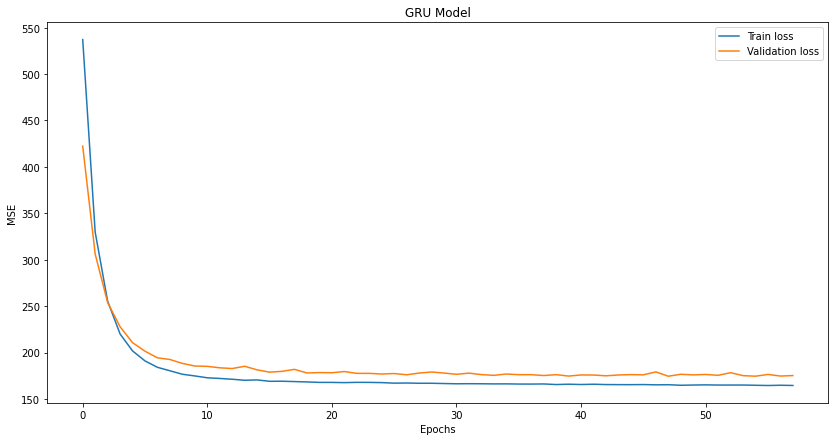

In [10]:
model1 = auto_model(64, 64, 0, 2018, 2021)

In [ ]:
model2 = auto_model(64, 32, 0, 2018, 2021)

In [ ]:
model3 = auto_model(64, 16, 0, 2018, 2021)

In [ ]:
model4 = auto_model(64, 8, 0, 2018, 2021)

# Test - web fix

In [ ]:
# data preprocessing for prediction january 2022

testing = df2021.copy()

testing['month_year'] = testing['tgl'].apply(lambda x: x.strftime('%m-%y')).astype(str)

testing['month_year'] = testing['month_year'].map({'01-21':0,'02-21':1,'03-21':2,'04-21':3,'05-21':4,'06-21':5,'07-21':6,'08-21':7,'09-21':8,'10-21':9,'11-21':10,'12-21':11})
# testing['month_year'] = testing['month_year'].map({'01-21':'Januari','02-21':'Februari','03-21':'Maret','04-21':'April','05-21':'Mei','06-21':'Juni','07-21':'Juli','08-21':'Agustus','09-21':'September','10-21':"Oktober",'11-21':'November','12-21':'Desember'})

test_monthly = testing[['tgl', 'month_year', 'barcode', 'qty']]
test_monthly = test_monthly.sort_values('tgl').groupby(['month_year', 'barcode'], as_index=False)
test_monthly = test_monthly.agg({'qty':['sum']})
test_monthly.columns = ['month_year', 'barcode', 'qty_cnt']
test_monthly = test_monthly.query('qty_cnt >= 0 and qty_cnt <= 50')

# Label
test_monthly['qty_cnt_month'] = test_monthly.sort_values('month_year').groupby(['barcode'])['qty_cnt'].shift(-1)

test_monthly_series = test_monthly.pivot_table(index=['barcode'], columns='month_year',values='qty_cnt', fill_value=0).reset_index()

In [ ]:
# display(test_monthly_series.nunique())
display(test_monthly_series.head())

In [ ]:
# data preprocessing for prediction february 2022

testing_pred = df2022.copy()

testing_pred = testing_pred.drop(['notxn', 'nonota', 'namabarang', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)

testing_pred['month_year'] = testing_pred['tgl'].apply(lambda x: x.strftime('%m-%y')).astype(str)

testing_pred['month_year'] = testing_pred['month_year'].map({'01-22':0,'02-22':1})

testing_monthly_pred = testing_pred[['tgl', 'month_year', 'barcode', 'qty']]
testing_monthly_pred = testing_monthly_pred.sort_values('tgl').groupby(['month_year', 'barcode'], as_index=False)
testing_monthly_pred = testing_monthly_pred.agg({'qty':['sum']})
testing_monthly_pred.columns = ['month_year', 'barcode', 'qty_cnt']
testing_monthly_pred = testing_monthly_pred.query('qty_cnt >= 0 and qty_cnt <= 50')

# Label
testing_monthly_pred['qty_cnt_month'] = testing_monthly_pred.sort_values('month_year').groupby(['barcode'])['qty_cnt'].shift(-1)

testing_monthly_series_pred = testing_monthly_pred.pivot_table(index=['barcode'], columns='month_year',values='qty_cnt', fill_value=0).reset_index()

In [ ]:
print(f"Min date from data set: {testing_pred['tgl'].min().date()}")
print(f"Max date from data set: {testing_pred['tgl'].max().date()}")
print("Prediksi bulan januari & februari, karena penjualan bulan maret hanya tercatat pada tanggal 1")

In [ ]:
testing_monthly_series_pred.head()

In [ ]:
pred_list = ['96770', '011747234207', '96842', '97162', '8992933211115', '8999999195670', '00100809', '9557062331128', '97515', '00149457']
df_pred_list = df[df['barcode'].isin(pred_list)].reset_index(drop=True)

In [ ]:
df_pred_grouped = df_pred_list.groupby(["barcode", "namabarang"]).size().reset_index().rename(columns={0:'count'})
product_list = df_pred_grouped['barcode'].to_list()
namabarang = df_pred_grouped['namabarang'].to_list()

In [ ]:
# get data selected product list from 2021 and 2022 for ploting on website

# product_list = ['011747233057', '011747234207', '055500130221']
# namabarang = ['DUA KELINCI KCG.GRG 10*750GR', 'DOLPIN GARAM 1000GR*12', 'SOS P.LANTAI ORANGE 750ML REFF']

selected_data_2021 = test_monthly_series[test_monthly_series['barcode'].isin(product_list)].reset_index(drop=True)
selected_data_2022 = testing_monthly_series_pred[testing_monthly_series_pred['barcode'].isin(product_list)].reset_index(drop=True)
selected_data_2021['namabarang'] = namabarang
selected_data_2022['namabarang'] = namabarang
selected_data_2021 = selected_data_2021[['barcode', 'namabarang', 0, 1, 2, 3,  4, 5, 6, 7, 8, 9, 10, 11]]
selected_data_2022 = selected_data_2022[['barcode', 'namabarang', 0, 1]]
selected_data_2021.rename(columns = {0:'Januari', 1:'Februari', 2:'Maret', 3:'April', 4:'Mei', 5:'Juni', 6:'Juli', 7:'Agustus', 8:'September', 9:'Oktober', 10:'November', 11:'Desember'}, inplace = True)
selected_data_2022.rename(columns = {0:'Januari', 1:'Februari'}, inplace = True)
# selected_data_2022.drop(['barcode', 'kodejenis'], axis=1, inplace=True)
# appenned_data = df.append()
# # df_train_raw.to_csv('df_train_raw_new.csv', index=False)
display(selected_data_2021)
display(selected_data_2022)
# display(appenned_data)

In [ ]:
# selected_data_2021.to_csv('riwayat_pred_jan.csv', index=False)
# selected_data_2021.drop(['Januari'], axis=1, inplace=True)
# selected_data_2021['Januari'] = selected_data_2022['Januari']
# selected_data_2021.to_csv('riwayat_pred_feb.csv', index=False)

In [ ]:
selected_data_2021

In [ ]:
# get 5 products for prediction

# product_list = ['011747233057', '011747234207', '055500130221']

# df_pred = test_monthly_series[test_monthly_series['barcode'].isin(product_list)].reset_index(drop=True) # 2021 data
# df_pred_2022 = testing_monthly_series_pred[testing_monthly_series_pred['barcode'].isin(product_list)].reset_index(drop=True) # 2022 data
# df_pred = df_pred.drop_duplicates(subset=['barcode', 'kodejenis'])
# df_pred.fillna(0, inplace=True)
# df_pred.drop(['barcode', 'kodejenis'], axis=1, inplace=True)

In [ ]:
# product_list = ['011747233057', '011747234207', '055500130221']

# df_pred_jan = test_monthly_series[test_monthly_series['barcode'].isin(product_list)].reset_index(drop=True)
# df_pred_jan.drop(['kodejenis'], axis=1, inplace=True)
# df_pred_jan.drop([0], axis=1, inplace=True)
# df_pred_jan.head()
# df_pred_jan.to_csv('df_pred_jan.csv', index=False)

In [ ]:
# get 5 products for prediction

# product_list = ['011747233057', '011747234207', '055500130221']

# df_pred_feb = testing_monthly_series_pred[testing_monthly_series_pred['barcode'].isin(product_list)].reset_index(drop=True)
# df_pred_feb.drop(['kodejenis'], axis=1, inplace=True)
# df_pred_feb
# df_pred_feb[0]
# df_pred_jan[12] = df_pred_feb[0]
# df_pred_jan
# df_pred_jan.to_csv('df_pred_feb.csv', index=False)

In [ ]:
# df_pred.to_csv('df_pred.csv', index=False)

In [ ]:
jan = pd.read_csv('./riwayat_pred_jan.csv')
feb = pd.read_csv('./riwayat_pred_feb.csv')

In [ ]:
# drop unnecessary column

X_jan = jan.drop_duplicates(subset=['barcode'])
X_jan.fillna(0, inplace=True)
X_jan.drop(['barcode', 'namabarang'], axis=1, inplace=True)

X_feb = feb.drop_duplicates(subset=['barcode'])
X_feb.fillna(0, inplace=True)
X_feb.drop(['barcode', 'namabarang'], axis=1, inplace=True)

In [ ]:
display(X_jan)
display(X_feb)

In [ ]:
# reshape the predict dataset

X_reshaped_jan = X_jan.values.reshape((X_jan.shape[0], X_jan.shape[1], 1))
display(X_reshaped_jan.shape)

X_reshaped_feb = X_feb.values.reshape((X_feb.shape[0], X_feb.shape[1], 1))
display(X_reshaped_feb.shape)

In [ ]:
# gru_model = load_model('gru_model-bs64_hn64_month0_year2020-2021.h5')
# gru_model = load_model('gru_model-bs64_hn64_month35.h5')
gru_model = load_model('gru_model-bs32_hn64_month35.h5')

In [ ]:
# predict the dataset

model_pred_jan = gru_model.predict(X_reshaped_jan)
model_pred_feb = gru_model.predict(X_reshaped_feb)

In [ ]:
model_pred_feb

In [ ]:
# get back the barcode to pairing the prediction

barcode_pred_jan = jan[['barcode', 'namabarang']]
barcode_pred_feb = feb[['barcode', 'namabarang']]

prediction_jan = pd.DataFrame(barcode_pred_jan[['barcode', 'namabarang']], columns=['barcode', 'namabarang'])
prediction_jan['prediction_january'] = pd.DataFrame(model_pred_jan)
display(prediction_jan)

prediction_feb = pd.DataFrame(barcode_pred_feb[['barcode', 'namabarang']], columns=['barcode', 'namabarang'])
prediction_feb['prediction_february'] = pd.DataFrame(model_pred_feb)
display(prediction_feb)

# pred.to_csv('gru_submission.csv', index=False)

In [ ]:
selected_data_2022

In [ ]:
pred_jan = prediction_jan["prediction_january"]
pred_feb = prediction_feb["prediction_february"]

In [ ]:
actual_jan = selected_data_2022['Januari']
actual_feb = selected_data_2022['Februari']

In [ ]:
def mape(actual, pred): #gru_model-bs32_hn64_month35.h5
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(actual_jan, pred_jan)
# mape(actual_feb, pred_feb)

In [ ]:
print('Prediction rmse:', np.sqrt(mean_squared_error(actual_jan, pred_jan)))
print('Prediction rmse:', np.sqrt(mean_squared_error(actual_feb, pred_feb)))

In [ ]:
def mape(actual, pred): #gru_model-bs64_hn64_month35.h5
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(actual, pred)

In [ ]:
print('Prediction rmse:', np.sqrt(mean_squared_error(actual, pred)))

In [ ]:
def mape(actual, pred): #gru_model-bs64_hn64_month0_year2020-2021.h5
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(actual, pred)

In [ ]:
print('Prediction rmse:', np.sqrt(mean_squared_error(actual, pred)))

# Grafik loss

In [ ]:
mse_data = {
    'label': ['hn8_bs8', 'hn8_bs16', 'hn8_bs32', 'hn8_bs64', 'hn16_bs8', 'hn16_bs16', 'hn16_bs32', 'hn16_bs64', 'hn32_bs8', 'hn32_bs16', 'hn32_bs32', 'hn32_bs64', 'hn64_bs8', 'hn64_bs16', 'hn64_bs32', 'hn64_bs64'],
    'train_loss': [18.2807, 18.0760, 18.1033, 18.0075, 18.0656, 18.0799, 17.9932, 17.9708, 18.1356, 17.9326, 17.9475, 18.1038, 18.3331, 18.0864, 18.0973, 18.1149],
    'val_loss': [20.2143, 20.1159, 20.2461, 20.3417, 20.2482, 20.1407, 20.2909, 20.3262, 20.1198, 20.1386, 20.3004, 20.4894, 20.3695, 20.1952, 20.2034, 20.3936]}
df_mse = pd.DataFrame(mse_data)

In [ ]:
sns.set(rc={'figure.figsize':(22,6)})
sns.lineplot(x="label", y="train_loss", data=df_mse)

In [ ]:
sns.set(rc={'figure.figsize':(22,6)})
sns.boxplot(x='label', y='train_loss', data=df_mse)